In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from scipy.stats import mannwhitneyu
from pathlib import Path

In [31]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

In [32]:
base_path = Path("simulation_results")
all_folders = base_path.glob("*pts*")

# Now in each folder for each pkl file open the observation list
# From the observation list get obs_list[-1]["fly"][0] the last fly position
# Generate a scatter plot for each condition with the last fly z position¨
# Chnage the color if the adhesion is on
# Save the figure in the base directory

save_path = base_path / "panel_adh.pdf"

controllers = ["cpg", "rule_based", "hybrid"]
terrain = ["flat", "blocks", "gapped", "mixed"]
adhesion = [True]

conditions = [(c, t) for t in terrain for c in controllers]
n_conditions = len(conditions)

#sim_time = 1.0
#init_time = 0.0
timestep = 1e-4
all_rows = []
all_colors = np.tile(["r", "b"], n_conditions)


start_pts = 0
all_dir = True

for controller, terrain in conditions:
    for adh in adhesion:
        path = base_path / f"{terrain}/{controller}"
        if not path.is_dir():
            print(f"Path {path} does not exist")
            continue
        all_pkl = list(path.glob("*.pkl"))
        assert len(all_pkl) > 1, f"Path {path} does not contain any pkl file"
        data_pts = []
        for pkl_file in all_pkl:
            with open(pkl_file, "rb") as f:
                try:
                    obs_list = pickle.load(f)
                except:
                    obs_list = []
            #assert len(obs_list) == sim_time * 10_000    
            if len(obs_list) > start_pts:
                if all_dir:
                    distance = np.linalg.norm(obs_list[-1]["fly"][0][:2] - obs_list[start_pts]["fly"][0][:2])
                else:
                    distance = obs_list[-1]["fly"][0][0] - obs_list[start_pts]["fly"][0][0]
                exp_len = (len(obs_list) - start_pts) * timestep
            else:
                distance = 0.0
                exp_len = 100
            speed = distance / exp_len
            all_rows.append([controller.lower(), terrain.lower(), adh, speed, distance])

speed_df = pd.DataFrame(
    all_rows, columns=["controller", "terrain", "adhesion", "speed", "distance"]
)
#speed_df.to_csv("outputs/mean_speed.csv", index=False)

In [33]:
# replace rule based with decentralized
speed_df["controller"].replace({"rule_based": "decentralized"}, inplace=True)
controllers[1] = "decentralized"

In [34]:
speed_df_norm = speed_df.copy()
for controller in controllers:
    full_speed = np.nanmean(speed_df[(speed_df["controller"] == controller) & (speed_df["terrain"] == "flat")]["speed"])
    print(full_speed)
    speed_df_norm.loc[speed_df_norm["controller"] == controller, "speed"] /= full_speed

14.42779445648193
10.571103700002034
14.50725402832031


In [35]:
#speed_df.iloc[speed_df["speed"].argmax()] = np.nan

In [36]:
print(
    speed_df[speed_df["terrain"] == "flat"]["speed"].min(),
    speed_df[speed_df["terrain"] == "flat"]["speed"].max(),
)
print(
    speed_df_norm[speed_df_norm["terrain"] != "flat"]["speed"].min(),
    speed_df_norm[speed_df_norm["terrain"] != "flat"]["speed"].max(),
)

10.010802586873373 14.84048334757487
0.05332065340885369 1.0219785627074889


/home/stimpfling/mambaforge/envs/sleap/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/stimpfling/mambaforge/envs/sleap/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/stimpfling/mambaforge/envs/sleap/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/stimpfling/mambaforge/envs/sleap/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/st

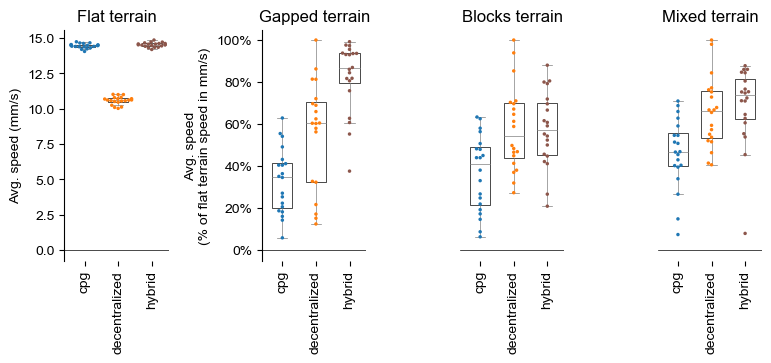

In [37]:

x_pos_lookup = {
    ("cpg", "flat"): 0,
    ("decentralized", "flat"): 1,
    ("hybrid", "flat"): 2,
    ("cpg", "gapped"): 5,
    ("decentralized", "gapped"): 6,
    ("hybrid", "gapped"): 7,
    ("cpg", "blocks"): 10,
    ("decentralized", "blocks"): 11,
    ("hybrid", "blocks"): 12,
    ("cpg", "mixed"): 15,
    ("decentralized", "mixed"): 16,
    ("hybrid", "mixed"): 17,
}
colors_lookup = {
    "cpg": "tab:blue",
    "decentralized": "tab:orange",
    "hybrid": "tab:brown",
}

fig, axs = plt.subplots(1, 4, figsize=(9, 3))
plt.subplots_adjust(wspace=0.9)
for i, terrain_type in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    ax.set_title(f"{terrain_type.title()} terrain")

    df = speed_df if terrain_type == "flat" else speed_df_norm
    ylim = [-0.15 * 10 / 1.15, 25] if terrain_type == "flat" else [-0.15, 1.15]

    boxplot = sns.boxplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        width=0.6,
        ax=ax,
        showfliers=False,
        boxprops={"facecolor": "None", "edgecolor": "k", "linewidth": 0.5},
        medianprops={"color": "gray", "linewidth": 0.5},
        whiskerprops={"color": "gray", "linewidth": 0.5},
        capprops={"color": "gray", "linewidth": 0.5},
    )
    sns.swarmplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        hue="controller",
        size=2.5,
        palette=["tab:blue", "tab:orange", "tab:brown"],
        ax=ax,
        legend=False,
    )
    ax.set_xlim(-0.6, 2.5)
    #ax.set_ylim(ylim)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.axhline(0.0, color="k", linewidth=0.5)
    if terrain_type not in ["flat", "gapped"]:
        ax.set_ylabel("")
        ax.set_yticks([])
        pass
    if terrain_type == "flat":
        ax.set_ylabel("Avg. speed (mm/s)")
    elif terrain_type == "gapped":
        ax.set_ylabel("Avg. speed\n(% of flat terrain speed in mm/s)")
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
    ax.set_xlabel("")
    sns.despine(ax=ax, bottom=True, left=terrain_type not in ["flat", "gapped"])

"""for i, terrain in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    N = df.query(f"terrain == '{terrain}'").groupby("controller")["speed"].apply(lambda x: np.sum(pd.notna(x)))
    x_axis_label = [f"{controller} (N={n})" for cont in controllers for controller, n in zip(N.index.values, N.values) if cont == controller]
    ax.set_xticks(range(3), x_axis_label, rotation=90)"""

#plt.savefig("outputs/speed_comparison.pdf", transparent=True)
plt.savefig("outputs/relspeed_comparison_2ddist_0stabilization.pdf", transparent=True, bbox_inches='tight')

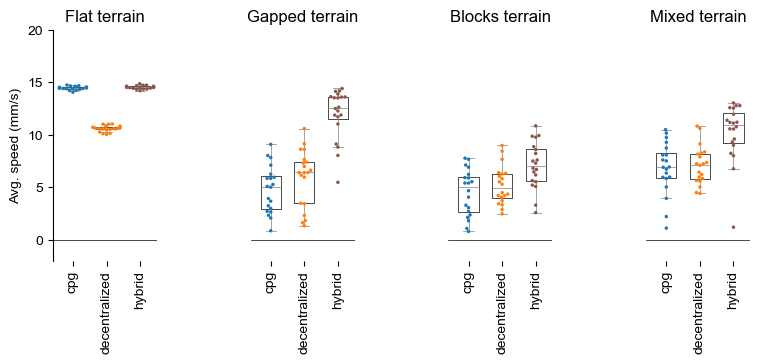

In [69]:

x_pos_lookup = {
    ("cpg", "flat"): 0,
    ("decentralized", "flat"): 1,
    ("hybrid", "flat"): 2,
    ("cpg", "gapped"): 3,
    ("decentralized", "gapped"): 4,
    ("hybrid", "gapped"): 5,
    ("cpg", "blocks"): 6,
    ("decentralized", "blocks"): 7,
    ("hybrid", "blocks"): 8,
    ("cpg", "mixed"): 9,
    ("decentralized", "mixed"): 10,
    ("hybrid", "mixed"): 11,
}
colors_lookup = {
    "cpg": "tab:blue",
    "decentralized": "tab:orange",
    "hybrid": "tab:brown",
}

fig, axs = plt.subplots(1, 4, figsize=(9, 3))
plt.subplots_adjust(wspace=0.9)
for i, terrain_type in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    ax.set_title(f"{terrain_type.title()} terrain")

    df = speed_df
    ylim = [-2.0, 20.0]

    boxplot = sns.boxplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        width=0.6,
        ax=ax,
        showfliers=False,
        boxprops={"facecolor": "None", "edgecolor": "k", "linewidth": 0.5},
        medianprops={"color": "gray", "linewidth": 0.5},
        whiskerprops={"color": "gray", "linewidth": 0.5},
        capprops={"color": "gray", "linewidth": 0.5},
    )
    sns.swarmplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        hue="controller",
        size=2.5,
        palette=["tab:blue", "tab:orange", "tab:brown"],
        ax=ax,
        legend=False,
        warn_thresh=1.0
    )
    ax.set_xlim(-0.6, 2.5)
    ax.set_ylim(ylim)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.axhline(0.0, color="k", linewidth=0.5)
    if terrain_type not in ["flat"]:
        ax.set_ylabel("")
        ax.set_yticks([])
        pass
    if terrain_type == "flat":
        ax.set_ylabel("Avg. speed (mm/s)")
    ax.set_xlabel("")
    sns.despine(ax=ax, bottom=True, left=terrain_type not in ["flat"])

"""for i, terrain in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    N = df.query(f"terrain == '{terrain}'").groupby("controller")["speed"].apply(lambda x: np.sum(pd.notna(x)))
    x_axis_label = [f"{controller} (N={n})" for cont in controllers for controller, n in zip(N.index.values, N.values) if cont == controller]
    ax.set_xticks(range(3), x_axis_label, rotation=90)"""

#plt.savefig("outputs/speed_comparison.pdf", transparent=True)20
plt.savefig("outputs/speed_comparison_2ddist_0stabilization.pdf", transparent=True, bbox_inches='tight')

In [39]:
# remove nans 
speed_df = speed_df.dropna()
speed_df_norm = speed_df_norm.dropna()

In [40]:
for variable, df in [("Absolute speed", speed_df), ("Normalized speed", speed_df_norm)]:
    for terrain_type in ["flat", "gapped", "blocks", "mixed"]:
        hybrid_pts = df[
            (df["controller"] == "hybrid") & (df["terrain"] == terrain_type)
        ]["speed"].values
        for controller in ["cpg", "decentralized"]:
            my_pts = df[
                (df["controller"] == controller) & (df["terrain"] == terrain_type)
            ]["speed"].values
            u, p = mannwhitneyu(
                my_pts, hybrid_pts, alternative="less", method="asymptotic"
            )
            print(f"{variable} - {terrain_type} - {controller} vs hybrid: {p:.6f}")

Absolute speed - flat - cpg vs hybrid: 0.066642
Absolute speed - flat - decentralized vs hybrid: 0.000000
Absolute speed - gapped - cpg vs hybrid: 0.000000
Absolute speed - gapped - decentralized vs hybrid: 0.000001
Absolute speed - blocks - cpg vs hybrid: 0.000977
Absolute speed - blocks - decentralized vs hybrid: 0.003856
Absolute speed - mixed - cpg vs hybrid: 0.000033
Absolute speed - mixed - decentralized vs hybrid: 0.000041
Normalized speed - flat - cpg vs hybrid: 0.526958
Normalized speed - flat - decentralized vs hybrid: 0.652554
Normalized speed - gapped - cpg vs hybrid: 0.000000
Normalized speed - gapped - decentralized vs hybrid: 0.000255
Normalized speed - blocks - cpg vs hybrid: 0.001070
Normalized speed - blocks - decentralized vs hybrid: 0.430215
Normalized speed - mixed - cpg vs hybrid: 0.000041
Normalized speed - mixed - decentralized vs hybrid: 0.104227


In [70]:
# find steady state
base_path = Path("simulation_results")
all_folders = base_path.glob("*pts*")

# Now in each folder for each pkl file open the observation list
# From the observation list get obs_list[-1]["fly"][0] the last fly position
# Generate a scatter plot for each condition with the last fly z position¨
# Chnage the color if the adhesion is on
# Save the figure in the base directory

save_path = base_path / "panel_adh.pdf"

controllers = ["cpg", "rule_based", "hybrid"]
terrain = ["flat", "blocks", "gapped", "mixed"]
adhesion = [True]

conditions = [(c, t) for t in terrain for c in controllers]
n_conditions = len(conditions)

#sim_time = 1.0
#init_time = 0.0
timestep = 1e-4
all_rows = []
all_colors = np.tile(["r", "b"], n_conditions)


start_pts = 0
all_dir = True

controller = "rule_based"
terrain = "flat"

path = base_path / f"{terrain}/{controller}"
all_pkl = list(path.glob("*.pkl"))
seed = []
assert len(all_pkl) > 1, f"Path {path} does not contain any pkl file"
all_obs_list = []
for pkl_file in all_pkl:
    seed.append(str(pkl_file).split("/")[-1][4:-20])
    with open(pkl_file, "rb") as f:
        try:
            obs_list = pickle.load(f)
        except:
            obs_list = []
    
    all_obs_list.append(obs_list)

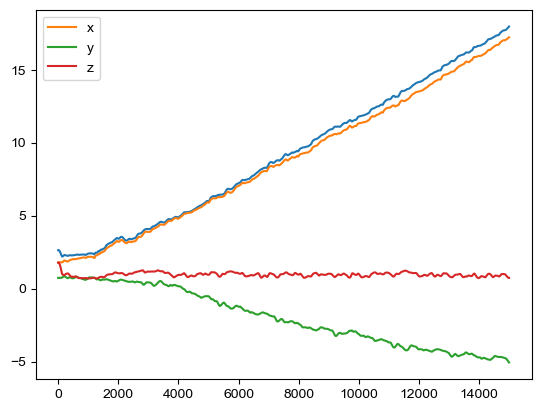

In [85]:
fly_speed = np.array([obs["fly"][0] for obs in all_obs_list[0]])
plt.plot(np.linalg.norm(fly_speed, axis=1))
plt.plot(fly_speed[:, 0], label="x")
plt.plot(fly_speed[:, 1], label="y")
plt.plot(fly_speed[:, 2], label="z")

plt.legend()


[ 1.00000002e+03 -4.33406698e-05  2.34545515e+00  1.12842594e-03
  6.29819489e-01]


/home/stimpfling/mambaforge/envs/sleap/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


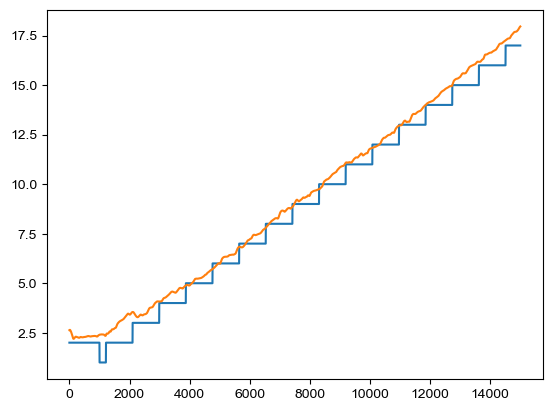

In [128]:
# fit piecewise linear function with two pieces to np.linalg.norm(fly_speed, axis=1) 
# Find two affine curves (a1*x+b1, a2*x+b2 and x0 but ensuring no discontinuity in x0) that fit the data best 

from scipy.optimize import curve_fit

def piecewise_linear(x, x0, a1, b1, a2, b2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x: a1*x + b1, lambda x: a2*x + b2])

x = np.arange(len(fly_speed))
p , _ = curve_fit(piecewise_linear, x, np.linalg.norm(fly_speed, axis=1), p0=[1000.0, 0.1, 0, 0.1, 0])
plt.plot(x, piecewise_linear(x, *p))
plt.plot(np.linalg.norm(fly_speed, axis=1))

print(p)

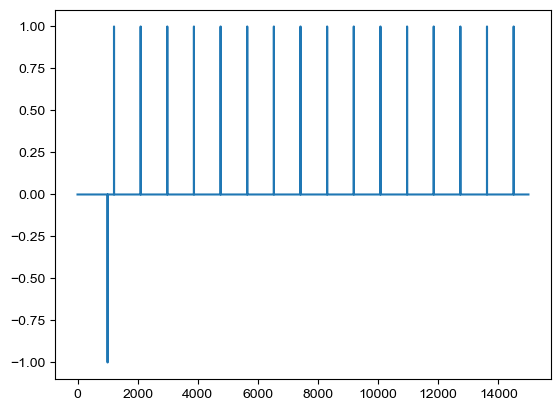

In [127]:
plt.plot(np.diff(piecewise_linear(x, *p)))

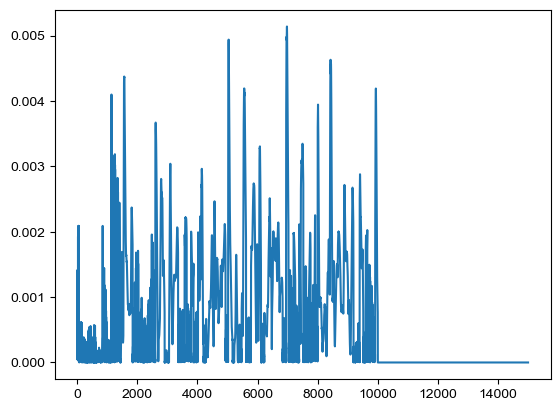

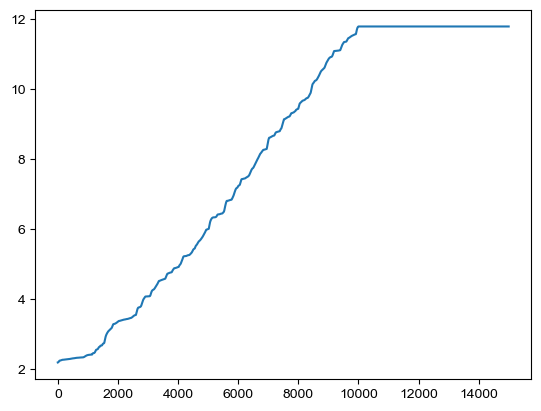

In [121]:
plt.plot(medfilt_norm)

In [87]:
p

array([3.90180435e+03, 4.72999799e+00, 7.40058892e-04, 1.17250951e-03])